In [1]:
#@author: Masayuki Ishimaru

In [2]:
# import library

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
import GPyOpt

import pickle

# Read regression model and parameters to scale back

In [3]:
with open('best_gaussr_RI.pickle', mode='rb') as f:
    best_gaussr_RI= pickle.load(f)

In [4]:
RI_mean_std_GPR = np.load('RI_mean_std_GPR.npy')

In [5]:
# read original data to know minimum and maximum values

df_clean = pd.read_csv('glass.csv')
print(df_clean.shape)
df_clean.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [6]:
# extract elements with transposed shape

df_comp_transpose = df_clean.describe().T[2:-1]
df_comp_transpose

,count,mean,std,min,25%,50%,75%,max
Na,214.0,13.407850,0.816604,10.73,12.9075,13.300,13.8250,17.38
Mg,214.0,2.684533,1.442408,0.00,2.1150,3.480,3.6000,4.49
Al,214.0,1.444907,0.499270,0.29,1.1900,1.360,1.6300,3.50
Si,214.0,72.650935,0.774546,69.81,72.2800,72.790,73.0875,75.41
K,214.0,0.497056,0.652192,0.00,0.1225,0.555,0.6100,6.21
Ca,214.0,8.956963,1.423153,5.43,8.2400,8.600,9.1725,16.19
Ba,214.0,0.175047,0.497219,0.00,0.0000,0.000,0.0000,3.15
Fe,214.0,0.057009,0.097439,0.00,0.0000,0.000,0.1000,0.51


In [7]:
min_val = df_comp_transpose['min']
max_val = df_comp_transpose['max']
min_val

Na    10.73
Mg     0.00
Al     0.29
Si    69.81
K      0.00
Ca     5.43
Ba     0.00
Fe     0.00
Name: min, dtype: float64

In [8]:
max_val

Na    17.38
Mg     4.49
Al     3.50
Si    75.41
K      6.21
Ca    16.19
Ba     3.15
Fe     0.51
Name: max, dtype: float64

In [9]:
max_val.index[0]

'Na'

# Function to minimize

In [10]:
# Get means and standard deviations

df_clean_mean = np.array(df_clean.iloc[:, 2:-1].mean(axis = 0))
df_clean_std  = np.array(df_clean.iloc[:, 2:-1].std(axis = 0))
print(df_clean_mean)
print(df_clean_std)

[1.34078505e+01 2.68453271e+00 1.44490654e+00 7.26509346e+01
 4.97056075e-01 8.95696262e+00 1.75046729e-01 5.70093458e-02]
[0.81660356 1.44240784 0.49926965 0.77454579 0.65219185 1.42315349
 0.49721926 0.0974387 ]


In [11]:
# function to minimize

def f_y(x):
    
    x_scaled = (x - df_clean_mean) / df_clean_std
    
    RI = best_gaussr_RI.predict(x_scaled) * RI_mean_std_GPR[1] + RI_mean_std_GPR[0]
    
    y = (RI - 1.523)**2
    
    return y

# Bayesian optimization

In [12]:
# composition range

bounds = [
        {'name': 'x[:, 0]',  'type': 'continuous', 'domain': (min_val[0],  max_val[0])},
        {'name': 'x[:, 1]',  'type': 'continuous', 'domain': (min_val[1],  max_val[1])},
        {'name': 'x[:, 2]',  'type': 'continuous', 'domain': (min_val[2],  max_val[2])},
        {'name': 'x[:, 3]',  'type': 'continuous', 'domain': (min_val[3],  max_val[3])},
        {'name': 'x[:, 4]',  'type': 'continuous', 'domain': (min_val[4],  max_val[4])},
        {'name': 'x[:, 5]',  'type': 'continuous', 'domain': (min_val[5],  max_val[5])},
        {'name': 'x[:, 6]',  'type': 'continuous', 'domain': (min_val[6],  max_val[6])},
        {'name': 'x[:, 7]',  'type': 'continuous', 'domain': (min_val[7],  max_val[7])}
        ]

In [13]:
# constraints

constraints = [
    {'name': 'constr_1',
    'constraint': '(x[:,0]+x[:,1]+x[:,2]+x[:,3]+x[:,4]+x[:,5]+x[:,6]+x[:,7]) - 100.0 - 0.01'},
    {'name': 'constr_2',
    'constraint': '100.0 - (x[:,0]+x[:,1]+x[:,2]+x[:,3]+x[:,4]+x[:,5]+x[:,6]+x[:,7]) - 0.01'}
]

# The first run to make the DataFrame base

In [14]:
import time
t1 = time.time()

np.random.seed(0)
optimizer = GPyOpt.methods.BayesianOptimization(
    f = f_y,
    domain = bounds,
    constraints = constraints,
    initial_design_numdata = 50,
    acquisition_type = 'MPI',
    )

optimizer.run_optimization(max_iter = 20)

t2 = time.time()
print('elapsed time = ', t2 - t1)

elapsed time =  114.41885924339294


In [15]:
# display results

print(optimizer.x_opt)
print(optimizer.x_opt.sum())
print(optimizer.fx_opt)

[10.82924183  1.97766318  3.03733959 70.21610209  2.18290249 11.08405127
  0.57934477  0.08335496]
99.99000019018698
1.4442083647484135e-11


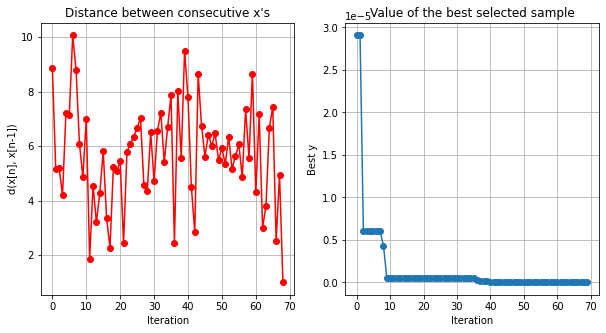

In [16]:
# check convergence

optimizer.plot_convergence()

In [17]:
# convert the 1st result to DataFrame

df_1st = pd.DataFrame(optimizer.x_opt).T
df_1st.columns = df_clean.columns.values[2:-1]
df_1st

,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,10.829242,1.977663,3.03734,70.216102,2.182902,11.084051,0.579345,0.083355


In [18]:
# check the result

x_scaled = (df_1st - df_clean_mean) / df_clean_std
    
RI_1st = best_gaussr_RI.predict(x_scaled) * RI_mean_std_GPR[1] + RI_mean_std_GPR[0]

print(RI_1st)

[1.5230038]


# Search additional solutions

In [19]:
# definition of function for different targets

def f_y_multi(x):
    
    x_scaled = (x - df_clean_mean) / df_clean_std
    
    RI = best_gaussr_RI.predict(x_scaled) * RI_mean_std_GPR[1] + RI_mean_std_GPR[0]
    
    y = (RI - RI_target)**2
    
    return y

In [20]:
def multiple_solution(RI_target, i):

    np.random.seed(i)
    optimizer = GPyOpt.methods.BayesianOptimization(
        f = f_y_multi,
        domain = bounds,
        constraints = constraints,
        initial_design_numdata = 50,
        acquisition_type = 'MPI',
        )

    optimizer.run_optimization(max_iter = 20)

    return optimizer.x_opt

In [21]:
t1 = time.time()
    
x_opt = np.array(df_1st)
RI_target_list = [1.5231, 1.5232, 1.5233, 1.5234, 1.5235]
i = 0

for RI_target in RI_target_list:
    x_opt_new = multiple_solution(RI_target, i)
    x_opt = np.vstack((x_opt, x_opt_new))

    t2 = time.time()
    print('Number of step = ', i+1, RI_target, '  elapsed time = ', t2-t1)
    
    i += 1
    
t2 = time.time()
print('elapsed time = ', t2 - t1)

Number of step =  1 1.5231   elapsed time =  126.83879804611206
Number of step =  2 1.5232   elapsed time =  311.91623997688293
Number of step =  3 1.5233   elapsed time =  456.82211208343506
Number of step =  4 1.5234   elapsed time =  635.3058545589447
Number of step =  5 1.5235   elapsed time =  752.3518524169922
elapsed time =  752.3518524169922


In [22]:
df_x_opt = pd.DataFrame(x_opt)
df_x_opt.columns = df_1st.columns
df_x_opt

,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,10.829242,1.977663,3.037340,70.216102,2.182902,11.084051,0.579345,0.083355
1,15.569647,0.368988,0.628261,71.994481,0.021972,11.120142,0.172084,0.114904
2,13.982675,1.629058,0.494386,69.907351,4.292990,9.437465,0.120551,0.138457
3,14.526097,4.379386,0.381573,70.944476,0.129333,7.426380,2.169510,0.033252
4,17.351361,0.213717,0.419624,69.998712,1.847690,7.741588,2.300861,0.117004
5,15.084774,1.842954,1.807952,70.145640,0.069628,10.229856,0.582876,0.226324


In [23]:
# check the result

x_scaled = (df_x_opt - df_clean_mean) / df_clean_std
    
RI_opt = best_gaussr_RI.predict(x_scaled) * RI_mean_std_GPR[1] + RI_mean_std_GPR[0]

print(RI_opt.reshape(-1,1))

[[1.5230038 ]
 [1.52309752]
 [1.52318807]
 [1.52328509]
 [1.52338389]
 [1.52349896]]


In [24]:
# save the solution

df_x_opt.to_csv('BO_solution.csv', index = None)